<a href="https://colab.research.google.com/github/ShauryaJain03/Transfer-Learning-Tensorflow/blob/main/transfer_learning_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fine-tuning**

In fine-tuning transfer learning the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

For feature extraction transfer learning, you may only train the top 1-3 layers of a pre-trained model with your own data, in fine-tuning transfer learning, you might train 1-3+ layers of a pre-trained model (where the '+' indicates that many or all of the layers could be trained).

 Feature extraction transfer learning vs. fine-tuning transfer learning. The main difference between the two is that in fine-tuning, more layers of the pre-trained model get unfrozen and tuned on custom data. This fine-tuning usually takes more data than feature extraction to be effective

We're going to go through the follow with TensorFlow:

- Introduce fine-tuning, a type of transfer learning to modify a pre-trained model to be more suited to your data
Using the Keras Functional API (a differnt way to build models in Keras)

- Using a smaller dataset to experiment faster (e.g. 1-10% of training samples of 10 classes of food)

- Data augmentation (how to make your training dataset more diverse without adding more data)

Running a series of modelling experiments on our Food Vision data

0. Model 0: a transfer learning model using the Keras Functional API
1. Model 1: a feature extraction transfer learning model on 1% of the data with data augmentation
2. Model 2: a feature extraction transfer learning model on 10% of the data with data augmentation
3. Model 3: a fine-tuned transfer learning model on 10% of the data
4. Model 4: a fine-tuned transfer learning model on 100% of the data
5. Introduce the ModelCheckpoint callback to save intermediate training results
6. Compare model experiments results using TensorBoard

In [9]:
import tensorflow as tf
import os

# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2024-01-13 20:06:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-13 20:06:24 (68.3 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [2]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-01-13 19:59:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 2607:f8b0:4023:c0b::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   144MB/s    in 1.1s    

2024-01-13 19:59:52 (144 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# Walk through 10 percent data directory and list number of files
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/gr

In [4]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [5]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


For now, the main parameters we're concerned about in the image_dataset_from_directory() funtion are:

directory - the filepath of the target directory we're loading images in from.

image_size - the target size of the images we're going to load in (height, width).

batch_size - the batch size of the images we're going to load in. For example if the batch_size is 32 (the default), batches of 32 images and labels at a time will be passed to the model.

In [6]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

(None, 224, 224, 3) refers to the tensor shape of our images where None is the batch size, 224 is the height (and width) and 3 is the color channels (red, green, blue).

(None, 10) refers to the tensor shape of the labels where None is the batch size and 10 is the number of possible labels (the 10 different food classes).

Both image tensors and labels are of the datatype tf.float32.

In [7]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [8]:
for images,labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[ 10.489796    9.489796    6.2040815]
   [  9.57653     8.933674    5.6479597]
   [  6.5918365   5.811224    4.377551 ]
   ...
   [  2.4285932   2.4285932   2.4285932]
   [  3.6173422   3.6173422   3.6173422]
   [  2.5152936   2.5152936   2.5152936]]

  [[  4.729592    4.80102     4.943877 ]
   [  7.913265    7.9846935   8.127551 ]
   [  6.2448983   6.3571434   5.872449 ]
   ...
   [  2.8724692   2.8724692   2.8724692]
   [  2.999987    2.999987    2.999987 ]
   [  1.7397635   1.7397635   1.7397635]]

  [[ 13.377549   15.9489765  20.306118 ]
   [  3.4438787   6.744899    9.530613 ]
   [  5.372449    7.280612    5.8979588]
   ...
   [  4.          4.          4.       ]
   [  3.9846911   3.9846911   3.9846911]
   [  3.7857141   3.7857141   3.7857141]]

  ...

  [[194.        198.        199.       ]
   [194.72958   198.72958   199.72958  ]
   [195.        199.        200.       ]
   ...
   [117.57138   116.785675  121.14279  ]
   [116.38773   115.60203   119.959145 ]
   [1

Notice how the image arrays come out as tensors of pixel values where as the labels come out as one-hot encodings (e.g. [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] for hamburger).

In [9]:
images.shape , labels.shape

(TensorShape([32, 224, 224, 3]), TensorShape([32, 10]))

# **Model 0: Building a transfer learning model using the Keras Functional API**

1. Instantiate a pre-trained base model object by choosing a target model such as EfficientNetV2B0 from tf.keras.applications.efficientnet_v2, setting the include_top parameter to False (we do this because we're going to create our own top, which are the output layers for the model).

2. Set the base model's trainable attribute to False to freeze all of the weights in the pre-trained model.

3. Define an input layer for our model, for example, what shape of data should our model expect?

[Optional] Normalize the inputs to our model if it requires. Some computer vision models such as ResNetV250 require their inputs to be between 0 & 1.

4. Pass the inputs to the base model.

5. Pool the outputs of the base model into a shape compatible with the output activation layer (turn base model output tensors into same shape as label tensors). This can be done using tf.keras.layers.GlobalAveragePooling2D() or tf.keras.layers.GlobalMaxPooling2D() though the former is more common in practice.

6. Create an output activation layer using tf.keras.layers.Dense() with the appropriate activation function and number of neurons.
7. Combine the inputs and outputs layer into a model using tf.keras.Model().
8. Compile the model using the appropriate loss function and choose of optimizer.
9. Fit the model for desired number of epochs and with necessary callbacks (in our case, we'll start off with the TensorBoard callback).

In [10]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

24274472/24274472 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20240113-200002
Epoch 1/5
24/24 [==============================] - 18s 253ms/step - loss: 1.8739 - accuracy: 0.4213 - val_loss: 1.3251 - val_accuracy: 0.6974
Epoch 2/5
24/24 [==============================] - 4s 171ms/step - loss: 1.1565 - accuracy: 0.7427 - val_loss: 0.8979 - val_accuracy: 0.8109
Epoch 3/5
24/24 [==============================] - 3s 129ms/step - loss: 0.8495 - accuracy: 0.8080 - val_loss: 0.7177 - val_accuracy: 0.8503
Epoch 4/5
24/24 [==============================] - 4s 172ms/step - loss: 0.6950 - accuracy: 0.8547 - val_loss: 0.6188 - val_accuracy: 0.8586
Epoch 5/5
24/24 [==============================] - 5s 195ms/step - loss: 0.6013 - accuracy: 0.8653 - val_loss: 0.5496 - val_accuracy: 0.8668


In [11]:
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 6s 70ms/step - loss: 0.5730 - accuracy: 0.8556


[0.5730195641517639, 0.8555999994277954]

In [12]:
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number , layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [13]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

You can see how each of the different layers have a certain number of parameters each. Since we are using a pre-trained model, you can think of all of these parameters are patterns the base model has learned on another dataset. And because we set base_model.trainable = False, these patterns remain as they are during training (they're frozen and don't get updated)

In [14]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

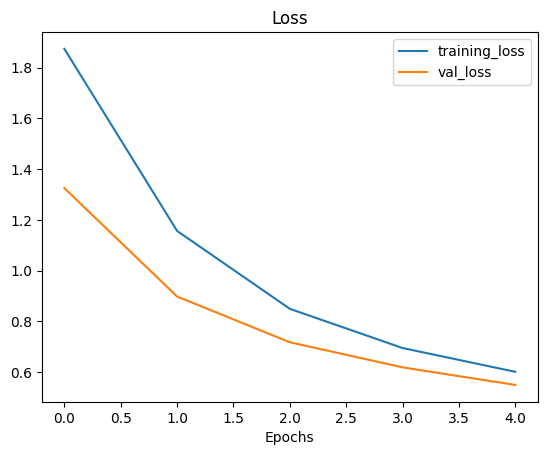

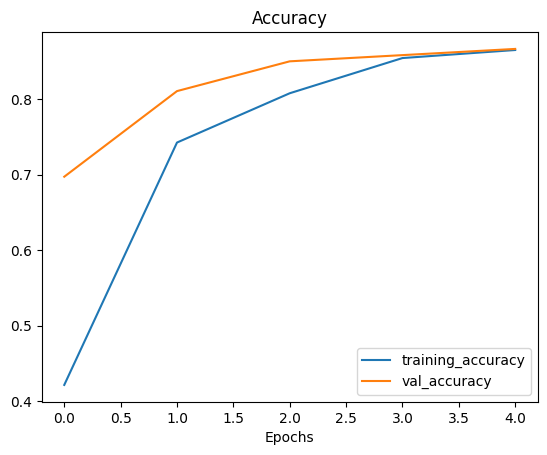

In [15]:
#plot loss crves
plot_loss_curves(history_10_percent)

GETTING FEATURE VECTOR FROM A TRAINED MODEL

The tf.keras.layers.GlobalAveragePooling2D() layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.

In [16]:
input_shape=(1,4,4,3)
input_tensor=tf.random.normal(input_shape)

#global-average pooled tensor
pooled_tensor=tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
pooled_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.04890552, -0.14426121,  0.10780659]], dtype=float32)>

You can see the tf.keras.layers.GlobalAveragePooling2D() layer condensed the input tensor from shape (1, 4, 4, 3) to (1, 3). It did so by averaging the input_tensor across the middle two axe

#### **Doing this not only makes the output of the base model compatible with the input shape requirement of our output layer (tf.keras.layers.Dense()), it also condenses the information found by the base model into a lower dimension feature vector.**

#### **Note: One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a feature vector (a long tensor of numbers, in our case, this is the output of the tf.keras.layers.GlobalAveragePooling2D() layer) which can then be used to extract patterns out of**

# **Model 1: Use feature extraction transfer learning on 1% of the training data with data augmentation.**

instead of implementing data augmentation in the ImageDataGenerator class as we have previously, we're going to build it right into the model using the tf.keras.layers module.

In [17]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
import zipfile
zip_ref=zipfile.ZipFile("10_food_classes_1_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2024-01-13 20:00:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   177MB/s    in 0.7s    

2024-01-13 20:00:59 (177 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [18]:
train_dir_1_percent="10_food_classes_1_percent/train"
test_dir="10_food_classes_1_percent/test"

In [19]:
import os
for dirpath,dirnames,filenames in os.walk("/content/10_food_classes_1_percent"):
  print(f"Found {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

Found 2 directories and 0 images in /content/10_food_classes_1_percent
Found 10 directories and 0 images in /content/10_food_classes_1_percent/train
Found 0 directories and 7 images in /content/10_food_classes_1_percent/train/chicken_wings
Found 0 directories and 7 images in /content/10_food_classes_1_percent/train/chicken_curry
Found 0 directories and 7 images in /content/10_food_classes_1_percent/train/fried_rice
Found 0 directories and 7 images in /content/10_food_classes_1_percent/train/sushi
Found 0 directories and 7 images in /content/10_food_classes_1_percent/train/hamburger
Found 0 directories and 7 images in /content/10_food_classes_1_percent/train/pizza
Found 0 directories and 7 images in /content/10_food_classes_1_percent/train/ramen
Found 0 directories and 7 images in /content/10_food_classes_1_percent/train/ice_cream
Found 0 directories and 7 images in /content/10_food_classes_1_percent/train/steak
Found 0 directories and 7 images in /content/10_food_classes_1_percent/trai

In [20]:
import tensorflow as tf
img_size=(224,224)
train_data_1_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,batch_size=32,image_size=img_size,label_mode="categorical")
test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,batch_size=32,image_size=img_size,label_mode="categorical")


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## **Adding data augmentation right into the model**
Previously we've used the different parameters of the ImageDataGenerator class to augment our training images, this time we're going to build data augmentation right into the model.

How?

Using the tf.keras.layers module and creating a dedicated data augmentation layer.

- Preprocessing of the images (augmenting them) happens on the GPU rather than on the CPU (much faster).
Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.

- Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could.

The data augmentation transformations we're going to use are:

- tf.keras.layers.RandomFlip - flips image on horizontal or vertical axis.
- tf.keras.layersRandomRotation - randomly rotates image by a specified amount.
- tf.keras.layers.RandomZoom - randomly zooms into an image by specified amount.
- tf.keras.layers.RandomHeight - randomly shifts image height by a specified amount.
- tf.keras.layers.RandomWidth - randomly shifts image width by a specified amount.
- tf.keras.layers.Rescaling - normalizes the image pixel values to be between 0 and 1, this is worth mentioning because it is required for some image models but since we're using tf.keras.applications.efficientnet_v2.EfficientNetV2B0, it's not required (the model pretrained model implements rescaling itself).

In [21]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
],name="data_augmentation")

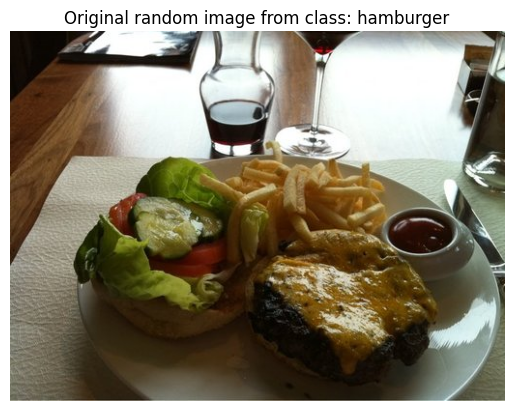

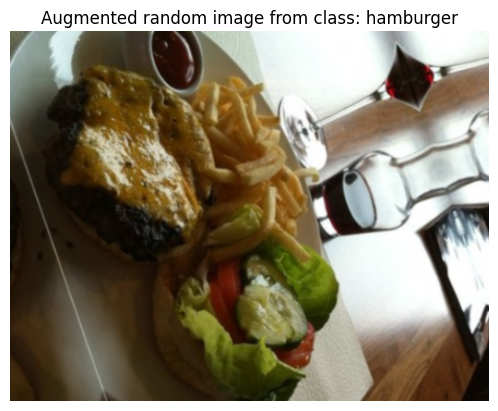

In [22]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

#input layer
inputs=tf.keras.layers.Input(shape=input_shape,name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = tf.keras.Model(inputs, outputs)

# compile the model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer="Adam",
                metrics=["accuracy"])

#fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240113-200105
Epoch 1/5


In [ ]:
model_1.summary()

The important thing to remember is data augmentation only runs during training. So if we were to evaluate or use our model for inference (predicting the class of an image) the data augmentation layers will be automatically turned off.

In [ ]:
# Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug


In [ ]:
# How does the model go with a data augmentation layer with 1% of data
plot_loss_curves(history_1_percent)

# **MODEL 2 -  Feature extraction transfer learning with 10% of data and data augmentation**

In [1]:
train_dir_10_percent="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"

In [2]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [3]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
],name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)
# Create a frozen base model
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable=False

 # augment our training images
inputs=tf.keras.layers.Input(shape=input_shape,name="input_layer")

 # augment our training images
x=data_augmentation(inputs)

# pass augmented images to base model but keep it in inference mode, so batchnorm layers dont get updated
x=base_model(x,training=False)

x=tf.keras.layers.GlobalAveragePooling2D(name="global_pooling_layer")(x)

outputs=tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

model_2=tf.keras.Model(inputs,outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])


## **Creating a ModelCheckpoint callback**

Our model is compiled and ready to be fit, so why haven't we fit it yet?

Well, for this experiment we're going to introduce a new callback, the ModelCheckpoint callback.

The ModelCheckpoint callback gives you the ability to save your model, as a whole in the SavedModel format or the weights (patterns) only to a specified directory as it trains.

This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there.

For example, say you fit a feature extraction transfer learning model for 5 epochs and you check the training curves and see it was still improving and you want to see if fine-tuning for another 5 epochs could help, you can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.

In [4]:
checkpoint_path="ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

The SavedModel format saves a model's architecture, weights and training configuration all in one folder. It makes it very easy to reload your model exactly how it is elsewhere.

However, if you do not want to share all of these details with others, you may want to save and share the weights only (these will just be large tensors of non-human interpretable numbers). If disk space is an issue, saving the weights only is faster and takes up less space than saving the whole model.

In [6]:

# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[
                                                     checkpoint_callback])


Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0712 - accuracy: 0.3067
Epoch 1: val_loss improved from inf to 1.53972, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 46s 1s/step - loss: 2.0712 - accuracy: 0.3067 - val_loss: 1.5397 - val_accuracy: 0.6447
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4225 - accuracy: 0.6693
Epoch 2: val_loss improved from 1.53972 to 1.12496, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 26s 1s/step - loss: 1.4225 - accuracy: 0.6693 - val_loss: 1.1250 - val_accuracy: 0.7368
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.1055 - accuracy: 0.7453
Epoch 3: val_loss improved from 1.12496 to 0.89106, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 26s 1s/step - loss: 1.1055 - accuracy: 0.7453 - val_loss: 0.

In [7]:
results_10_percent_data_aug=model_2.evaluate(test_data)

79/79 [==============================] - 7s 89ms/step - loss: 0.6739 - accuracy: 0.8280


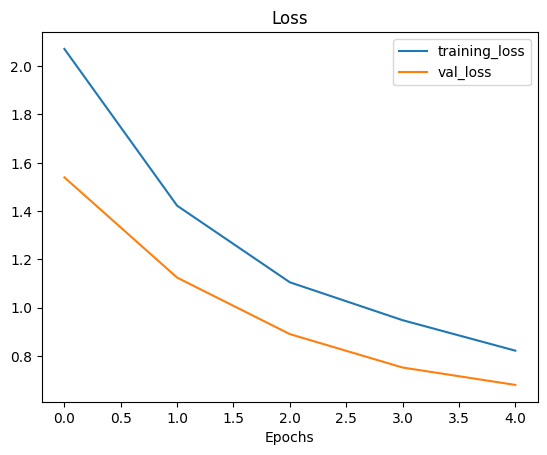

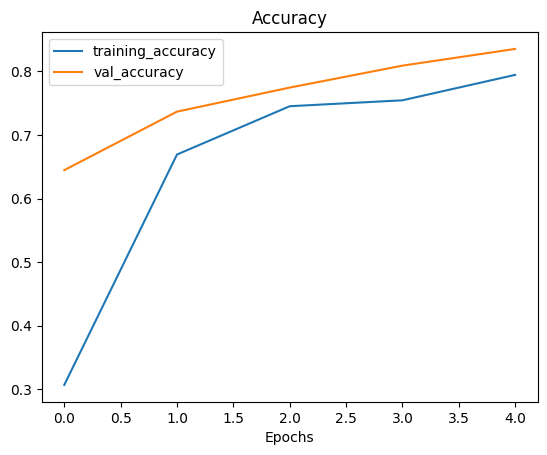

In [10]:
plot_loss_curves(history_10_percent_data_aug)

Looking at these, our model's performance with 10% of the data and data augmentation isn't as good as the model with 10% of the data without data augmentation (see model_0 results above), however the curves are trending in the right direction, meaning if we decided to train for longer, its metrics would likely improve.

Since we checkpointed (is that a word?) our model's weights, we might as well see what it's like to load it back in. We'll be able to test if it saved correctly by evaluting it on the test data.

In [13]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results=model_2.evaluate(test_data)

79/79 [==============================] - 9s 96ms/step - loss: 0.6739 - accuracy: 0.8280


In [14]:
# If the results from our native model and the loaded weights are the same, this should output True
results_10_percent_data_aug == loaded_weights_model_results

True

If the above cell doesn't output True, it's because the numbers are close but not the exact same (due to how computers store numbers with degrees of precision).

However, they should be very close...

In [15]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

# **FINE TUNING MODEL_3**

High-level example of fine-tuning an EfficientNet model. Bottom layers (layers closer to the input data) stay frozen where as top layers (layers closer to the output data) are updated during training.

So far our saved model has been trained using feature extraction transfer learning for 5 epochs on 10% of the training data and data augmentation.

This means all of the layers in the base model (EfficientNetV2B0) were frozen during training.

For our next experiment we're going to switch to fine-tuning transfer learning. This means we'll be using the same base model except we'll be unfreezing some of its layers (ones closest to the top) and running the model for a few more epochs.

The idea with fine-tuning is to start customizing the pre-trained model more to our own data.

- 🔑 Note: Fine-tuning usually works best after training a feature extraction model for a few epochs and with large amounts of data. For more on this, check out Keras' guide on Transfer learning & fine-tuning.

In [16]:
model_2.layers

In [18]:
#are these trainable layers
for layer in model_2.layers:
  print(f"{layer}  - {layer.trainable}")

<keras.src.engine.input_layer.InputLayer object at 0x7ab4d5356c80>  - True
<keras.src.engine.sequential.Sequential object at 0x7ab4d53547c0>  - True
<keras.src.engine.functional.Functional object at 0x7ab4b91b2950>  - False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7ab4d4122b60>  - True
<keras.src.layers.core.dense.Dense object at 0x7ab4d532e530>  - True


We've got an input layer, a Sequential layer (the data augmentation model), a Functional layer (EfficientNetV2B0), a pooling layer and a Dense layer (the output layer).

In [19]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_pooling_layer (Glob  (None, 1280)              0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                             

t looks like all of the layers in the efficientnetv2-b0 layer are frozen. We can confirm this using the trainable_variables attribute.

In [21]:
model_2.layers[2].trainable_variables #empty array suggests that this layer has no trainable layers
#model_2.layers[2] is the same as the base_model it is the functional layer i.e our efficientnet_v2

[]

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

Now to fine-tune the base model to our own data, we're going to unfreeze the top 10 layers and continue training our model for another 5 epochs.

This means all of the base model's layers except for the last 10 will remain frozen and untrainable. And the weights in the remaining unfrozen layers will be updated during training.

Ideally, we should see the model's performance improve.

In [ ]:
model_2.layers[2].trainable=True
for layer_num,layer in enumerate(model_2.layers[2].layers):
  print(f"{layer.name} - {layer.trainable}")

In [35]:
#freeze all layers except last 10
for layer in model_2.layers[2].layers[:-10]:
  layer.trainable=False

# Recompile the whole model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [ ]:
#now lets check the layers which are trainabe and which are not
for layer in model_2.layers[2].layers:
  print(f"{layer.name} - {layer.trainable}")

Nice! It seems all layers except for the last 10 are frozen and untrainable.

 This means only the last 10 layers of the base model along with the output layer will have their weights updated during training.

In our case, we're using the exact same loss, optimizer and metrics as before, except this time the learning rate for our optimizer will be 10x smaller than before (0.0001 instead of Adam's default of 0.001).

We do this so the model doesn't try to overwrite the existing weights in the pretrained model too fast. In other words, we want learning to be more gradual.

🔑 Note: There's no set standard for setting the learning rate during fine-tuning, though reductions of 2.6x-10x+ seem to work well in practice.

In [38]:
len(model_2.trainable_variables)

12

Wonderful, it looks like our model has a total of 12 trainable variables, the last 10 layers of the base model and the weight and bias parameters of the Dense output layer.

Time to fine-tune!

We're going to continue training on from where our previous model finished. Since it trained for 5 epochs, our fine-tuning will begin on the epoch 5 and continue for another 5 epochs.

To do this, we can use the initial_epoch parameter of the fit() method. We'll pass it the last epoch of the previous model's training history (history_10_percent_data_aug.epoch[-1]).

In [39]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)))

Epoch 5/10
24/24 [==============================] - 29s 838ms/step - loss: 0.7191 - accuracy: 0.7947 - val_loss: 0.5688 - val_accuracy: 0.8109
Epoch 6/10
24/24 [==============================] - 19s 769ms/step - loss: 0.6081 - accuracy: 0.8027 - val_loss: 0.5078 - val_accuracy: 0.8487
Epoch 7/10
24/24 [==============================] - 18s 727ms/step - loss: 0.5527 - accuracy: 0.8307 - val_loss: 0.4992 - val_accuracy: 0.8372
Epoch 8/10
24/24 [==============================] - 15s 625ms/step - loss: 0.5085 - accuracy: 0.8427 - val_loss: 0.4857 - val_accuracy: 0.8421
Epoch 9/10
24/24 [==============================] - 19s 782ms/step - loss: 0.5137 - accuracy: 0.8240 - val_loss: 0.5123 - val_accuracy: 0.8306
Epoch 10/10
24/24 [==============================] - 17s 690ms/step - loss: 0.4349 - accuracy: 0.8640 - val_loss: 0.4653 - val_accuracy: 0.8438


In [40]:
results_fine_tune_10_percent=model_2.evaluate(test_data)

79/79 [==============================] - 6s 69ms/step - loss: 0.4420 - accuracy: 0.8500


In [41]:
results_10_percent_data_aug

[0.6738719940185547, 0.828000009059906]

## **hence we get 3% more accuracy because of unfreezing top 10 layers and fine tuning**

In [44]:
import matplotlib.pyplot as plt
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.30666667222976685, 0.6693333387374878, 0.7453333139419556, 0.7546666860580444, 0.7946666479110718, 0.7946666479110718, 0.8026666641235352, 0.8306666612625122, 0.8426666855812073, 0.8240000009536743, 0.8640000224113464]


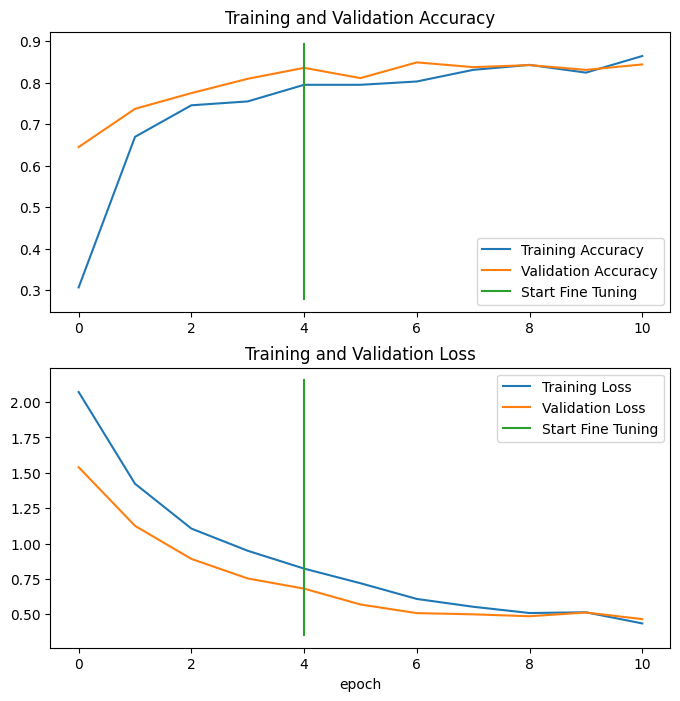

In [45]:

compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_percent_data_aug,
                 initial_epochs=5)